Reference to: https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

In this article, we will work with historical data about the stock prices of a publicly listed company. We will implement a mix of machine learning algorithms to predict the future stock price of this company, starting with simple algorithms **like averaging and linear regression, and then move on to advanced techniques like Auto ARIMA and LSTM.**

This repo focuses on the technical analysis part, not fundamental analysis.

In [1]:
# load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

df = pd.read_csv('NSE-TATAGLOBAL11.csv')

In [2]:
# show the top 5 row of the dataset
df.head(5)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


Note, there are multiple variables in the dataset – date, open, high, low, last, close, total_trade_quantity, and turnover.

The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.
High, Low and Last represent the maximum, minimum, and last price of the share for the day.
Total Trade Quantity is the number of shares bought or sold in the day and Turnover (Lacs) is the turnover of the particular company on a given date.

In [3]:
# use close price as target variable
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.index = df['Date']

/Applications/anaconda3/envs/aml/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


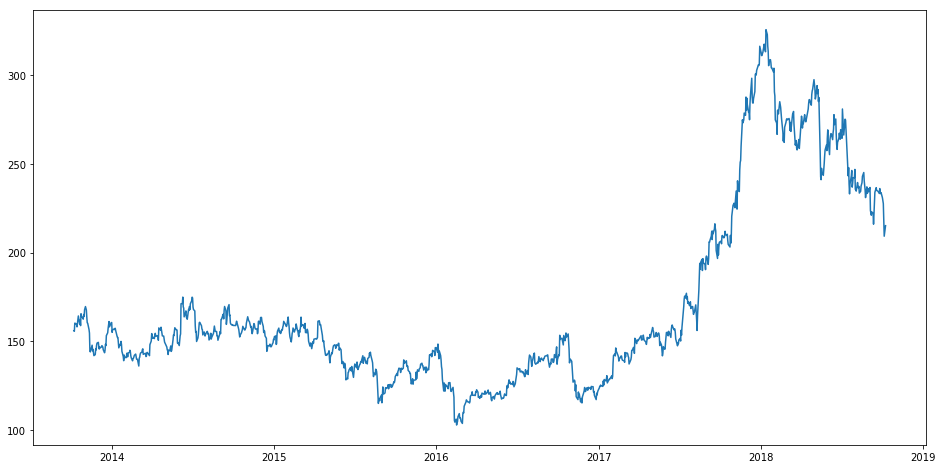

In [4]:
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price History')

### Moving Average

In [5]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = data[['Date', 'Close']]

In [6]:
#splitting into train and validation
train = new_data[:987]
valid = new_data[987:]

In [7]:
new_data.shape, train.shape, valid.shape

((1235, 2), (987, 2), (248, 2))

In [8]:
#make predictions
preds = []
# average 248 days, meaning the sliding window size is 248 days
for i in range(0, 248):
    a = train['Close'][len(train)-248+i:].sum() + sum(preds)
    b = a/248
    preds.append(b)

In [9]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))

In [10]:
rms

104.51415465984356

/Applications/anaconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


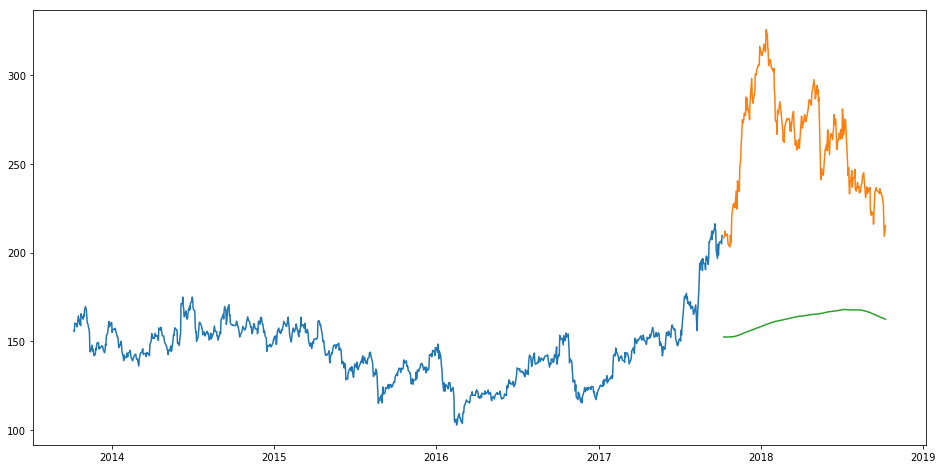

In [11]:
#plot
plt.figure(figsize=(16, 8))
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

From my perspective, moving average method is quite impractical. Mainly for 2 reasons:
1. Sliding window size has big impact for the prediction value. In above plot, we can notice that although there is a huge fall after 2018, the prediction value is still increasing. And because it's the overall average, **it neglects the large amplitude of stock price changing**.
2. Just same as above point, moving average has **obvious lag effect**. It's not sensitive to market change. 

### Linear Regression

In [12]:
linear_data = new_data.copy()
#create features
from fastai.structured import add_datepart
add_datepart(linear_data, 'Date')
linear_data.drop('Elapsed', axis=1, inplace=True)  # elapsed will be the time stamp, unnecessary

This creates features such as:

‘Year’, ‘Month’, ‘Week’, ‘Day’, ‘Dayofweek’, ‘Dayofyear’, ‘Is_month_end’, ‘Is_month_start’, ‘Is_quarter_end’, ‘Is_quarter_start’,  ‘Is_year_end’, and  ‘Is_year_start’.

In [13]:
# created a feature that identifies whether a given day is Monday/Friday or Tuesday/Wednesday/Thursday.
linear_data['mon_fri'] = linear_data['Dayofweek']
dic = {0: 1, 4: 1, 1: 0, 2: 0, 3:0, 5:0, 6:0}
linear_data['mon_fri'] = linear_data['mon_fri'].map(dic)

In [14]:
#split into train and validation
train = linear_data[:987]
valid = linear_data[987:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [15]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

121.16291596523405

/Applications/anaconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


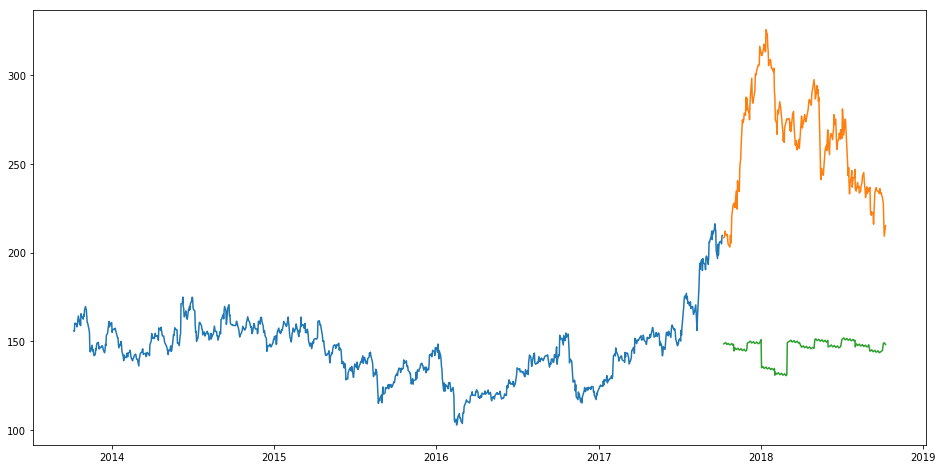

In [16]:
valid['Predictions'] = preds

# valid.index = linear_data[987:].index
# train.index = linear_data[:987].index
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

In [17]:
model.coef_

array([  -0.45938,  221.25734,   -0.01716,    7.20411,    0.22974,   -7.24255,    0.494  ,   -1.40111,
         -2.39146,   -2.18545,    3.93764,   19.50362,    0.05713])

In [18]:
x_train.head()

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,mon_fri
Date,,,,,,,,,,,,,
2013-10-08,2013,10,41,8,1,281,False,False,False,False,False,False,0
2013-10-09,2013,10,41,9,2,282,False,False,False,False,False,False,0
2013-10-10,2013,10,41,10,3,283,False,False,False,False,False,False,0
2013-10-11,2013,10,41,11,4,284,False,False,False,False,False,False,1
2013-10-14,2013,10,42,14,0,287,False,False,False,False,False,False,1


Problem:
1. the model overfits to the date and month column. Instead of taking into account the previous values from the point of prediction, the model will consider the value from the same date a month ago, or the same date/month a year ago.
2. Do not use the value of target, not good for time series prediciton.

### k-Nearest Neighbours

In [19]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [20]:
# Using the same train and validation set from the last section
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

/Applications/anaconda3/envs/aml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/envs/aml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/envs/aml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

115.17086550026723

/Applications/anaconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


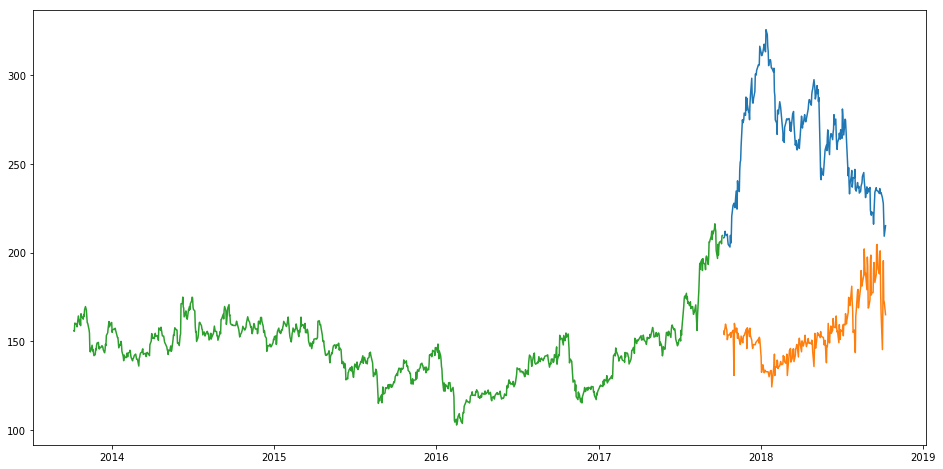

In [22]:
#plot
valid['Predictions'] = preds
plt.figure(figsize=(16, 8))
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

The RMSE value is almost similar to the linear regression model and the plot shows the same pattern. Like linear regression, kNN also identified a drop in January 2018 since that has been the pattern for the past years. We can safely say that regression algorithms have not performed well on this dataset.

From my point, there is too less feature to support the prediction of stock price. 

### Auto ARIMA

ARIMA is a very popular statistical method for time series forecasting. ARIMA models take into account the past values to predict the future values. There are three important parameters in ARIMA:

* p (past values used for forecasting the next value)

* q (past forecast errors used to predict the future values)

* d (order of differencing)

In [23]:
from pyramid.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:987]
valid = data[987:]

training = train['Close']
#validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, 
                   seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=248)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4820.561, BIC=4844.968, Fit time=2.347 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5479.245, BIC=5489.008, Fit time=0.058 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5170.275, BIC=5189.801, Fit time=0.659 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4818.530, BIC=4838.055, Fit time=1.836 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4816.433, BIC=4840.840, Fit time=1.625 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5170.275, BIC=5189.801, Fit time=0.606 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4818.339, BIC=4847.628, Fit time=8.136 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5481.156, BIC=5495.800, Fit time=0.155 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=4818.604, BIC=4852.774, Fit time=6.761 seconds
Fit ARIMA: order=(1, 1, 1) s

In [24]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

44.955373584706692

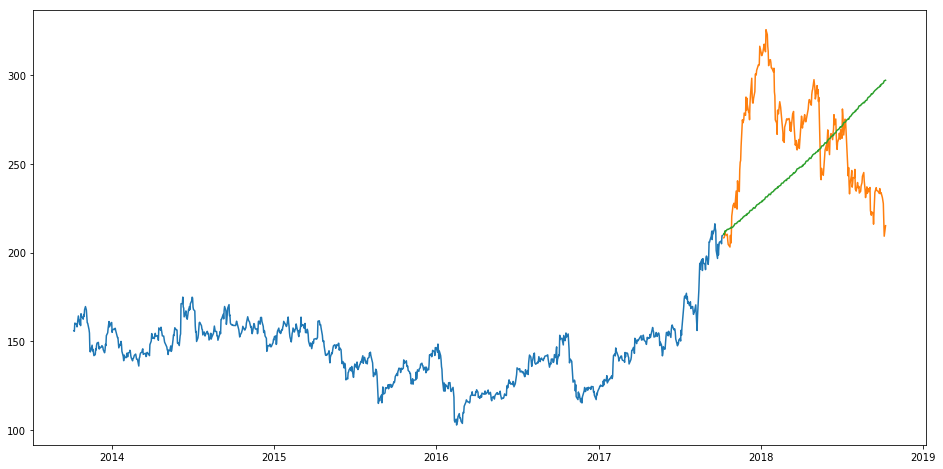

In [25]:
#plot
plt.figure(figsize=(16, 8))
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

As we saw earlier, an auto ARIMA model uses past data to understand the pattern in the time series. Using these values, the model captured an increasing trend in the series. 

As it's evident from the plot, the model has captured a trend in the series, but does not focus on the seasonal part. In the next section, we will implement a time series model that takes both trend and seasonality of a series into account.

### Prophet

Prophet, designed and pioneered by Facebook, is a time series forecasting library that requires no data preprocessing and is extremely simple to implement. The input for Prophet is a dataframe with two columns: date and target (ds and y).

In [26]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [27]:
#preparing data
prophet_data = new_data.copy()
prophet_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = prophet_data[:987]
valid = prophet_data[987:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
#rmse
forecast_valid = forecast['yhat'][987:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

57.461756853455093

/Applications/anaconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


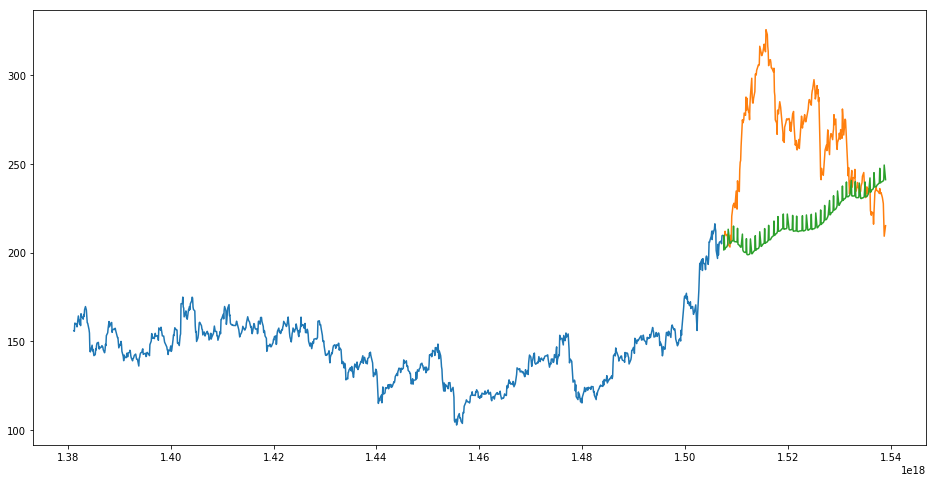

In [29]:
#plot
valid['Predictions'] = forecast_valid.values
plt.figure(figsize=(16, 8))
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

Prophet (like most time series forecasting techniques) tries to capture the trend and seasonality from past data. 

**As it turns out, stock prices do not have a particular trend or seasonality. It highly depends on what is currently going on in the market and thus the prices rise and fall.** Hence forecasting techniques like ARIMA, SARIMA and Prophet would not show good results for this particular problem.

### LSTM

In [30]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [31]:
lstm_data = new_data.copy()
lstm_data.drop('Date', axis=1, inplace=True)
dataset = lstm_data.values
train = dataset[0:987]
valid = dataset[987:]

In [32]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [33]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [34]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [37]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

preds = []
# average 60 days, meaning the sliding window size is 60 days
for i in range(0, 60):
    inputs = np.append(train[len(train)-60+i:], preds)
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)
    x_test = np.reshape(inputs, (1, inputs.shape[0], 1))
    next_pred = model.predict(x_test)
    next_pred = scaler.inverse_transform(next_pred)[0]
    preds.append(next_pred)

Epoch 1/1
 - 142s - loss: 0.0012


In [38]:
rms=np.sqrt(np.mean(np.power((valid[:60]-preds),2)))
rms

59.251374819190559

/Applications/anaconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


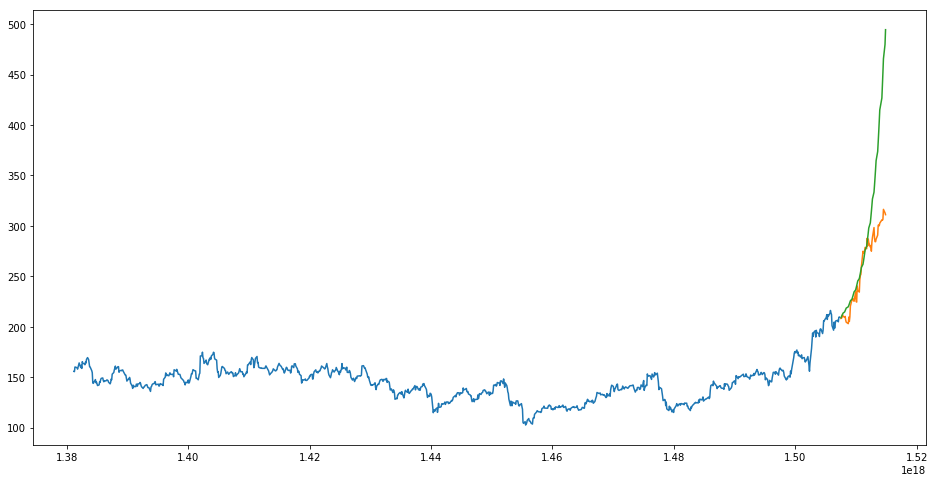

In [39]:
#for plotting
lstm_data = new_data.copy()
plt.figure(figsize=(16, 8))
train_plot = lstm_data[:987]
valid_plot = lstm_data[987:987+60]
valid_plot['Predictions'] = preds
plt.plot(train_plot['Close'])
plt.plot(valid_plot[['Close','Predictions']])

It shows that though LSTM can use previous information, however, the window size matters. Also, there are many factors outside the price itself. 